In [1]:
import os
os.chdir("../../")
print(os.getcwd())

import pandas as pd
import numpy as np
import torch
from torch.distributions import Uniform
import matplotlib.pyplot as plt

from models.sv_class import Sv

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis


/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis"
  warnings.warn(
/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/vy/fmgkssl15p50c836x934qygw0000gn/T//RtmpJf0Qqu", R: "/var/folders/vy/fmgkssl15p50c836x934qygw0000gn/T//RtmpzQNltM"
  warnings.warn(


In [20]:
data = pd.read_csv('data/spx_spot.csv')
s = data['close'].to_numpy()
ret = np.log(s[1:] / s[:-1])

dt = torch.tensor(1 / 252)

#sigma_y_true = torch.tensor(0.2) * torch.sqrt(dt)    # Long term vol of returns
sigma_y_true = torch.tensor(0.01)
#sigma_h_true = torch.tensor(0.25) * torch.sqrt(dt)  # vol of log-variance
sigma_h_true = torch.tensor(0.25)
phi_true = torch.tensor(0.9)
rho_true = torch.tensor(-0.5)
#mu_true = torch.tensor(0.0) * dt
mu_true = torch.tensor(0.001)

model = Sv(sigma_y_true, sigma_h_true, phi_true, rho_true, mu_true, ret)

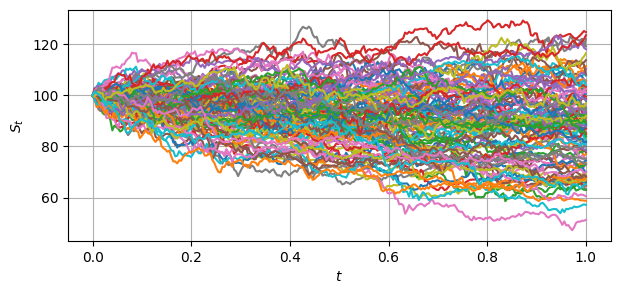

In [19]:
torch.manual_seed(42)

x0 = torch.tensor(np.log(100.0))
T = torch.tensor(1.0)
dt = torch.tensor(1 / 252)

x, h = model.simulate(x0, T, dt, 100)
S = torch.exp(x)

plt.figure(figsize=(7, 3))
plt.plot(torch.linspace(0, T, len(S)), S)
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

In [16]:
torch.manual_seed(42)
t = S.shape[0] - 1

n_paths = S.shape[1]
n_params = 5
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 500
grad_norm_threshold = 0.1
for i in range(n_paths):
    print(i)
    sigma_y = Uniform(low=1e-4, high=1.0).sample()
    sigma_h = Uniform(low=1e-4, high=1.0).sample()
    phi = Uniform(low=-0.99, high=0.99).sample()
    rho = Uniform(low=-0.99, high=0.0).sample()
    mu = mu_true

    ret = torch.log(S[1:, i] / S[:-1, i]).numpy()
    model = Sv(sigma_y, sigma_h, phi, rho, mu, ret)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward()
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))

        #print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}")
        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            print("Maximum iteration reached.")
        optimizer.step()

    params = model.get_params()
    stats["mle"][i, 0] = params['sigma_y']
    stats["mle"][i, 1] = params['sigma_h']
    stats["mle"][i, 2] = params['phi']
    stats["mle"][i, 3] = params["rho"]
    stats["mle"][i, 4] = params["mu"]


0
1
2
3
4
5
6
7
Maximum iteration reached.
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Maximum iteration reached.
29
Maximum iteration reached.
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
Maximum iteration reached.
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
Maximum iteration reached.
95
96
97
98
99


In [17]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
n_no_conv = stats["no_convergence"]

print(f"Average MLE: sigma_y:{mean[0].item():.3f}, sigma_h:{mean[1].item():.3f}, phi:{mean[2].item():.3f}, rho:{mean[3].item():.3f}, mu:{mean[4].item():.3f}")
print(f"Std MLE: sigma_y:{std[0].item():.3f}, sigma_h:{std[1].item():.3f}, phi:{std[2].item():.3f}, rho:{std[3].item():.3f}, mu:{std[4].item():.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv} / {n_paths}")

Average MLE: sigma_y:0.010, sigma_h:0.277, phi:0.774, rho:-0.430, mu:0.001
Std MLE: sigma_y:0.001, sigma_h:0.196, phi:0.356, rho:0.435, mu:0.000
Average number of iteration to convergence 262.420
Number of parameters where GD didn't converge: 5 / 100
